In [55]:
from fastai.vision.all import load_learner, PILImage
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
import json
import pandas as pd
import os
from fastai.vision.all import *
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import matplotlib.transforms as mtransforms

In [56]:
# --- Parameter ---
TEST_JSON_PATH = "../train_test_split_new.json"
BASE_PATH = "../basemodel_outputs"
MODEL_PATHS = [
    f"{BASE_PATH}/ViT_bs64+augm+iNat.pkl",
    f"{BASE_PATH}/googlenet_bs128+aug.pkl",
    f"{BASE_PATH}/resnet50_bs16+aug+iNat.pkl"
]

DISTANCE_METRICS = ["euclidean", "manhattan", "cosine", "faiss_euclidean", "faiss_cosine"]

# --- 1. Testdaten laden ---
with open(TEST_JSON_PATH, "r") as f:
    split = json.load(f)

df_test = pd.DataFrame(split["test"])
df_test['file_path'] = df_test['file_path'].apply(lambda x: os.path.join("..", "balanced_dataset_split", "balanced_dataset_split", x))

df_test.head()

file_path  \
0  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0221.JPG   
1  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0230.JPG   
2  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0231.JPG   
3  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0233.JPG   
4  ../balanced_dataset_split/balanced_dataset_split/test/acinonyx jubatus/acinonyx jubatus_20140307-PICT0234.JPG   

              label  
0  acinonyx jubatus  
1  acinonyx jubatus  
2  acinonyx jubatus  
3  acinonyx jubatus  
4  acinonyx jubatus

In [ ]:
def load_model_outputs():
    model_outputs = {}
    file_map = {
        "ViT": "features_ViT_bs64+augm+iNat.npz",
        "ResNet50": "features_resnet50_bs16+aug+iNat.npz",
        "GoogLeNet": "features_googlenet_bs128+aug.npz"
    }

    for model_name, filename in file_map.items():
        if os.path.exists(filename):
            data = np.load(filename)
            model_outputs[model_name] = {
                "features": data["features"],
                "labels": data["labels"]
            }
        else:
            print(f"⚠️ Datei nicht gefunden: {filename}")
    
    return model_outputs

model_outputs = load_model_outputs()


def search(query_feat, database_feats, metric="euclidean", top_k=5):
    if metric == "cosine":
        sims = cosine_similarity([query_feat], database_feats)[0]
        top_indices = np.argsort(sims)[::-1][:top_k]
        scores = sims[top_indices]
    elif metric == "euclidean":
        dists = euclidean_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
        scores = dists[top_indices]
    elif metric == "manhattan":
        dists = manhattan_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
        scores = dists[top_indices]
    
    else:
        raise ValueError("Unknown metric")
    
    return top_indices, scores


# --- Metriken ---
def precision_at_k(query_label, retrieved_labels, k):
    correct = sum([1 for label in retrieved_labels[:k] if label == query_label])
    return correct / k

def average_precision(query_label, retrieved_labels):
    relevant = [1 if label == query_label else 0 for label in retrieved_labels]
    if sum(relevant) == 0:
        return 0
    precisions = [precision_at_k(query_label, retrieved_labels, k+1) for k in range(len(relevant)) if relevant[k]]
    return np.mean(precisions)




In [58]:
def generate_gradcam(model, img_path, target_layer, device, target_class_idx=None):
    # Bild laden und vorbereiten
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Grad-CAM initialisieren
    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=None)
    
    targets = None
    if target_class_idx is not None:
        targets = [ClassifierOutputTarget(target_class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # Overlay erzeugen
    rgb_img = np.array(img.resize((224, 224))) / 255.0
    if rgb_img.shape[-1] == 4:  # PNG transparency check
        rgb_img = rgb_img[..., :3]
    visualization = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)
    
    return visualization

In [59]:
def visualize_query_results_with_gradcam_and_originals(query_idx, model_name, metric_name, df_test, model_outputs, model, target_layer, top_k=5):
    """
    Zeigt Query + Top-K Ergebnisse: jeweils Originalbild und Grad-CAM Overlay
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval().to(device)

    features_array = model_outputs[model_name]["features"]
    labels_array = model_outputs[model_name]["labels"]

    query_path = df_test.iloc[query_idx]['file_path']
    query_feat = features_array[query_idx]
    query_label = labels_array[query_idx]

    top_indices, scores = search(query_feat, features_array, metric=metric_name, top_k=top_k + 1)
    top_indices = top_indices[1:]
    scores = scores[1:]
    retrieved_labels = labels_array[top_indices]

    fig, axes = plt.subplots(2, top_k + 1, figsize=(20, 6))

    # Query Original
    axes[0,0].imshow(Image.open(query_path))
    axes[0,0].set_title(f"Query Original\n{query_label}", fontsize=10)
    axes[0,0].axis('off')

    # Query Grad-CAM
    query_img_gradcam = generate_gradcam(model, query_path, target_layer, device)
    axes[1,0].imshow(query_img_gradcam)
    axes[1,0].set_title(f"Query Grad-CAM", fontsize=10)
    axes[1,0].axis('off')

    # Retrievals: Original und Grad-CAM
    for i, (idx, score) in enumerate(zip(top_indices, scores)):
        img_path = df_test.iloc[idx]['file_path']
        label = labels_array[idx]
        correct = (label == query_label)
        color = 'green' if correct else 'red'
        metric_label = f"{'Sim' if metric_name == 'cosine' else 'Dist'}: {score:.3f}"

        # Originalbild
        axes[0,i+1].imshow(Image.open(img_path))
        axes[0,i+1].set_title(f"Rank {i+1}\n{label}\n{metric_label}", fontsize=9, color=color)
        axes[0,i+1].axis('off')

        # Grad-CAM Overlay
        retrieved_img_gradcam = generate_gradcam(model, img_path, target_layer, device)
        axes[1,i+1].imshow(retrieved_img_gradcam)
        #axes[1,i+1].set_title(f"Grad-CAM {i+1}", fontsize=9, color=color)
        axes[1,i+1].axis('off')

    plt.suptitle(f"Model: {model_name} | Metric: {metric_name}", fontsize=14)
    plt.tight_layout()
    save_path = f"{model_name}_{metric_name}_query{query_idx}.pdf"
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()


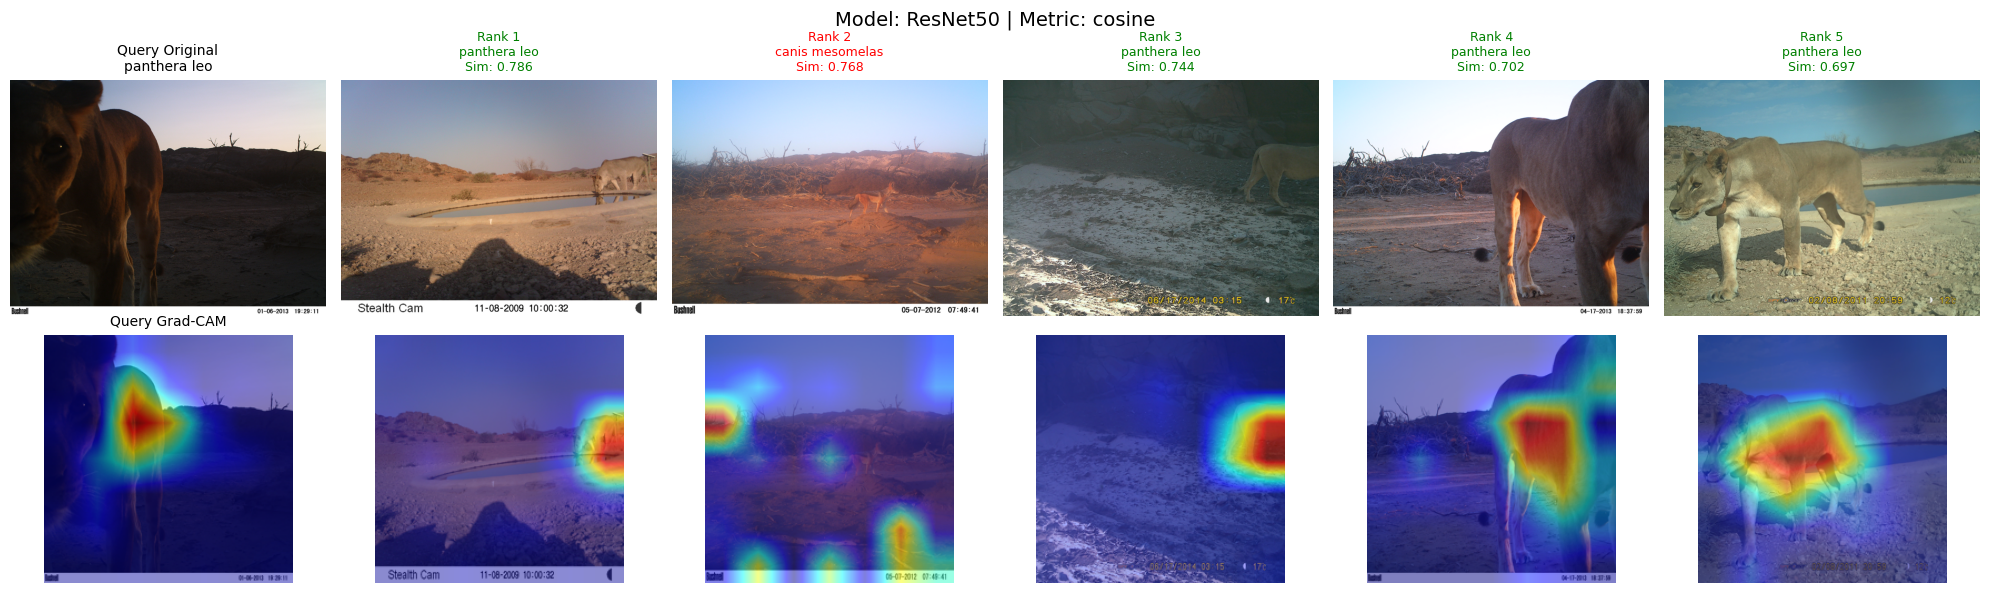

In [19]:
# ResNet50 with Grad-CAM

learn = load_learner('../basemodel_outputs/resnet50_bs16+aug+iNat.pkl')
model = learn.model

target_layer = model[0][-1]  # oder anpassen je nach Modellstruktur

visualize_query_results_with_gradcam_and_originals(
    query_idx=1422,
    model_name="ResNet50",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    model=model,
    target_layer=target_layer,
    top_k=5
)

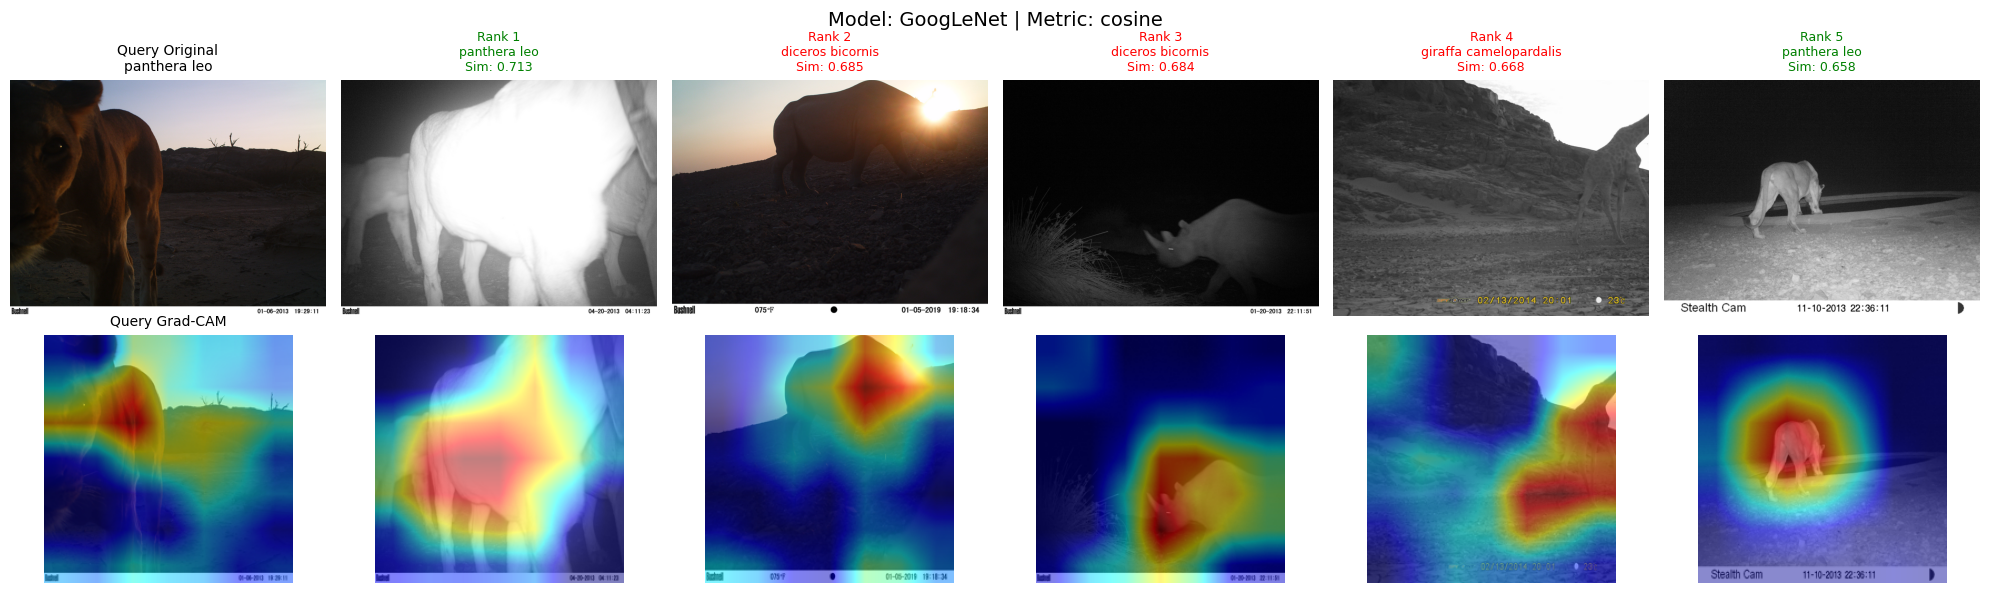

In [21]:
# GoogLeNet with Grad-CAM

learn = load_learner('../basemodel_outputs/googlenet_bs128+aug.pkl')
model = learn.model

target_layer = model[0][-1] 

visualize_query_results_with_gradcam_and_originals(
    query_idx=1422,
    model_name="GoogLeNet",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    model=model,
    target_layer=target_layer,
    top_k=5
)

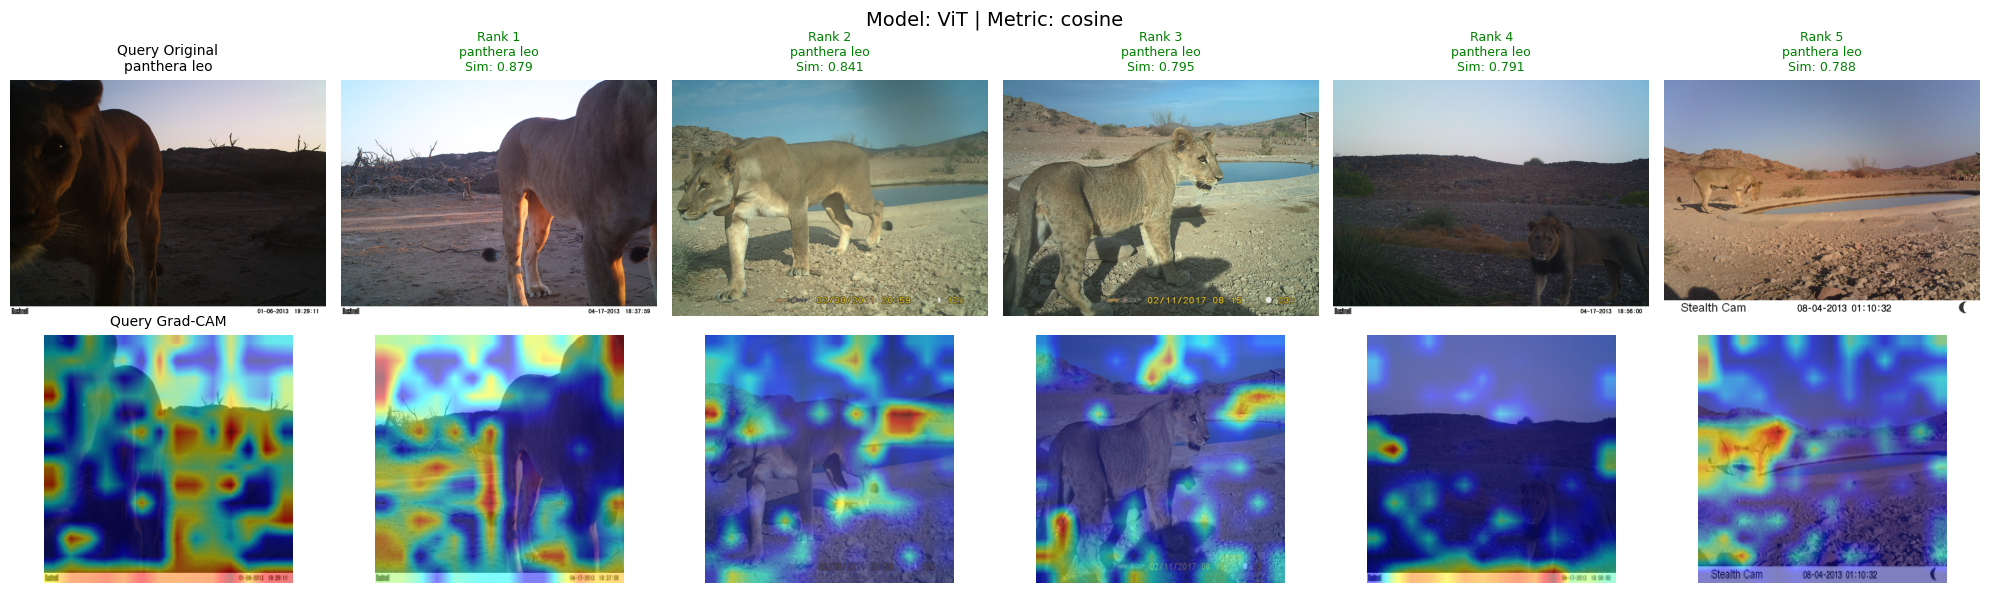

In [ ]:
# ViT with Grad-CAM

learn_vit = load_learner('../basemodel_outputs/ViT_bs64+augm+iNat.pkl')
model_vit = learn_vit.model

# Target Layer für Grad-CAM
target_layer_vit = model_vit.blocks[-2].norm1

# reshape_transform für Vision Transformer
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

def generate_gradcam(model, img_path, target_layer, device, target_class_idx=None, reshape_transform=None):
    """
    Erzeugt ein Grad-CAM Overlay für ein gegebenes Bild.
    """
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)

    targets = None
    if target_class_idx is not None:
        targets = [ClassifierOutputTarget(target_class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    rgb_img = np.array(img.resize((224, 224))) / 255.0
    if rgb_img.shape[-1] == 4:
        rgb_img = rgb_img[..., :3]  # falls PNG mit Transparenz
    visualization = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

    return visualization

def visualize_query_results_with_gradcam_and_originals(
    query_idx, model_name, metric_name, df_test, model_outputs, model, target_layer, top_k=5, reshape_transform=None
):
    """
    Zeigt Query + Top-K Ergebnisse mit Originalbild und Grad-CAM Overlay an.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval().to(device)

    features_array = model_outputs[model_name]["features"]
    labels_array = model_outputs[model_name]["labels"]

    query_path = df_test.iloc[query_idx]['file_path']
    query_feat = features_array[query_idx]
    query_label = labels_array[query_idx]

    top_indices, scores = search(query_feat, features_array, metric=metric_name, top_k=top_k + 1)
    top_indices = top_indices[1:]  # Query selbst entfernen
    scores = scores[1:]
    retrieved_labels = labels_array[top_indices]

    fig, axes = plt.subplots(2, top_k + 1, figsize=(20, 6))

    # Query Originalbild
    axes[0, 0].imshow(Image.open(query_path))
    axes[0, 0].set_title(f"Query Original\n{query_label}", fontsize=10)
    axes[0, 0].axis('off')

    # Query Grad-CAM
    query_img_gradcam = generate_gradcam(model, query_path, target_layer, device, reshape_transform=reshape_transform)
    axes[1, 0].imshow(query_img_gradcam)
    axes[1, 0].set_title(f"Query Grad-CAM", fontsize=10)
    axes[1, 0].axis('off')

    # Retrievals
    for i, (idx, score) in enumerate(zip(top_indices, scores)):
        img_path = df_test.iloc[idx]['file_path']
        label = labels_array[idx]
        correct = (label == query_label)
        color = 'green' if correct else 'red'
        metric_label = f"{'Sim' if metric_name == 'cosine' else 'Dist'}: {score:.3f}"

        # Originalbild
        axes[0, i+1].imshow(Image.open(img_path))
        axes[0, i+1].set_title(f"Rank {i+1}\n{label}\n{metric_label}", fontsize=9, color=color)
        axes[0, i+1].axis('off')

        # Grad-CAM Overlay
        retrieved_img_gradcam = generate_gradcam(model, img_path, target_layer, device, reshape_transform=reshape_transform)
        axes[1, i+1].imshow(retrieved_img_gradcam)
        axes[1, i+1].axis('off')

    plt.suptitle(f"Model: {model_name} | Metric: {metric_name}", fontsize=14)
    save_path = f"{model_name}_{metric_name}_query{query_idx}.pdf"
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.tight_layout()
    plt.savefig("ViT_1422_vorletzterBlock_layer.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Visualisierung aufrufen
visualize_query_results_with_gradcam_and_originals(
    query_idx=1422,
    model_name="ViT",
    metric_name="cosine",
    df_test=df_test,
    model_outputs=model_outputs,
    model=model_vit,
    target_layer=target_layer_vit,
    top_k=5,
    reshape_transform=reshape_transform  
)

In [63]:
def visualize_vit_two_layers_gradcam(
    query_idx, df_test, model_outputs, model, layer1, layer2, model_name="ViT", metric_name="cosine", top_k=5
):
    """
    Vergleicht zwei ViT-Layer (z. B. letzter & vorletzter Block) per Grad-CAM übereinander.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval().to(device)

    reshape_fn = reshape_transform
    features_array = model_outputs[model_name]["features"]
    labels_array = model_outputs[model_name]["labels"]

    query_path = df_test.iloc[query_idx]['file_path']
    query_feat = features_array[query_idx]
    query_label = labels_array[query_idx]

    top_indices, scores = search(query_feat, features_array, metric=metric_name, top_k=top_k + 1)
    top_indices = top_indices[1:]
    scores = scores[1:]
    retrieved_labels = labels_array[top_indices]

    fig, axes = plt.subplots(2, top_k + 1, figsize=(20, 6))

    # Query Grad-CAM für beide Layer
    gradcam_query_layer1 = generate_gradcam(model, query_path, layer1, device, reshape_transform=reshape_fn)
    gradcam_query_layer2 = generate_gradcam(model, query_path, layer2, device, reshape_transform=reshape_fn)

    axes[0, 0].imshow(gradcam_query_layer1)
    axes[0, 0].set_title("Query – Penultimate Transformer Block (LayerNorm)", fontsize=10)
    axes[0, 0].axis('off')

    axes[1, 0].imshow(gradcam_query_layer2)
    axes[1, 0].set_title("Query – Final Transformer Block (LayerNorm)", fontsize=10)
    axes[1, 0].axis('off')

    # Retrievals
    for i, (idx, score) in enumerate(zip(top_indices, scores)):
        img_path = df_test.iloc[idx]['file_path']
        label = labels_array[idx]
        color = 'green' if label == query_label else 'red'
        metric_label = f"{'Sim' if metric_name == 'cosine' else 'Dist'}: {score:.3f}"

        gradcam_layer1 = generate_gradcam(model, img_path, layer1, device, reshape_transform=reshape_fn)
        gradcam_layer2 = generate_gradcam(model, img_path, layer2, device, reshape_transform=reshape_fn)

        axes[0, i+1].imshow(gradcam_layer1)
        axes[0, i+1].set_title(f"Rank {i+1} – Penultimate\n{label}\n{metric_label}", fontsize=9, color=color)
        axes[1, i+1].set_title(f"Final Transformer Block", fontsize=9)

        axes[0, i+1].axis('off')

        axes[1, i+1].imshow(gradcam_layer2)
        axes[1, i+1].axis('off')

    plt.suptitle(f"ViT Grad-CAM Comparison – Penultimate vs. Final Transformer Block (Query {query_idx})", fontsize=14)
    save_path = f"ViT_layers_query{query_idx}.pdf"
    plt.tight_layout()
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()

visualize_vit_two_layers_gradcam(
    query_idx=1422,
    df_test=df_test,
    model_outputs=model_outputs,
    model=model_vit,
    layer1=model_vit.blocks[-2].norm1,  # Vorletzter Block
    layer2=model_vit.blocks[-1].norm1,  # Letzter Block
    model_name="ViT",
    metric_name="cosine",
    top_k=5
)


In [ ]:
def generate_gradcam(model, img_path, target_layer, device, target_class_idx=None, reshape_transform=None):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)

    targets = None
    if target_class_idx is not None:
        targets = [ClassifierOutputTarget(target_class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    grayscale_cam -= np.min(grayscale_cam)
    grayscale_cam /= (np.max(grayscale_cam) + 1e-8)

    rgb_img = np.array(img.resize((224, 224))) / 255.0
    if rgb_img.shape[-1] == 4:
        rgb_img = rgb_img[..., :3]

    visualization = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

    return visualization

def visualize_all_gradcams(query_idx, df_test, model_outputs, models_info, top_k=5, save_path="gradcam_combined.pdf"):
    """
    Große Grad-CAM Übersicht mit Modellnamen gedreht links.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    n_rows = len(models_info)
    n_cols = top_k + 1  # Query + Top-k

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))

    if n_rows == 1:
        axes = np.expand_dims(axes, 0)  # Ensure 2D array

    for row_idx, model_info in enumerate(models_info):
        model = model_info["model"].eval().to(device)
        model_name = model_info["model_name"]
        target_layer = model_info["target_layer"]
        reshape_transform = model_info.get("reshape_transform", None)

        features_array = model_outputs[model_name]["features"]
        labels_array = model_outputs[model_name]["labels"]

        query_path = df_test.iloc[query_idx]['file_path']
        query_feat = features_array[query_idx]

        top_indices, scores = search(query_feat, features_array, metric="cosine", top_k=top_k + 1)
        top_indices = top_indices[1:]

        # Query Grad-CAM
        query_img_gradcam = generate_gradcam(model, query_path, target_layer, device, reshape_transform=reshape_transform)
        axes[row_idx, 0].imshow(query_img_gradcam)
        axes[row_idx, 0].set_title("Query", fontsize=14)
        axes[row_idx, 0].axis('off')

        # Retrievals Grad-CAMs
        for col_idx, idx in enumerate(top_indices):
            img_path = df_test.iloc[idx]['file_path']
            retrieved_img_gradcam = generate_gradcam(model, img_path, target_layer, device, reshape_transform=reshape_transform)
            axes[row_idx, col_idx + 1].imshow(retrieved_img_gradcam)
            axes[row_idx, col_idx + 1].set_title(f"Rank {col_idx + 1}", fontsize=12)
            axes[row_idx, col_idx + 1].axis('off')

        # Modellname links neben der Zeile, vertikal gedreht
        trans = mtransforms.blended_transform_factory(fig.transFigure, axes[row_idx, 0].transAxes)
        fig.text(
            0.005,  # Abstand von links
            (axes[row_idx, 0].get_position().y0 + axes[row_idx, 0].get_position().y1) / 2,  # vertikale Mitte
            model_name,
            va='center', ha='center',
            rotation='vertical',
            fontsize=16,
            fontweight='bold'
        )

    plt.tight_layout()
    plt.subplots_adjust(left=0.1)  # Platz für Modellnamen links lassen
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    print(f"Grad-CAM Übersicht gespeichert unter: {save_path}")
    plt.show()

✅ Grad-CAM Übersicht gespeichert unter: gradcam_combined_query1422.pdf


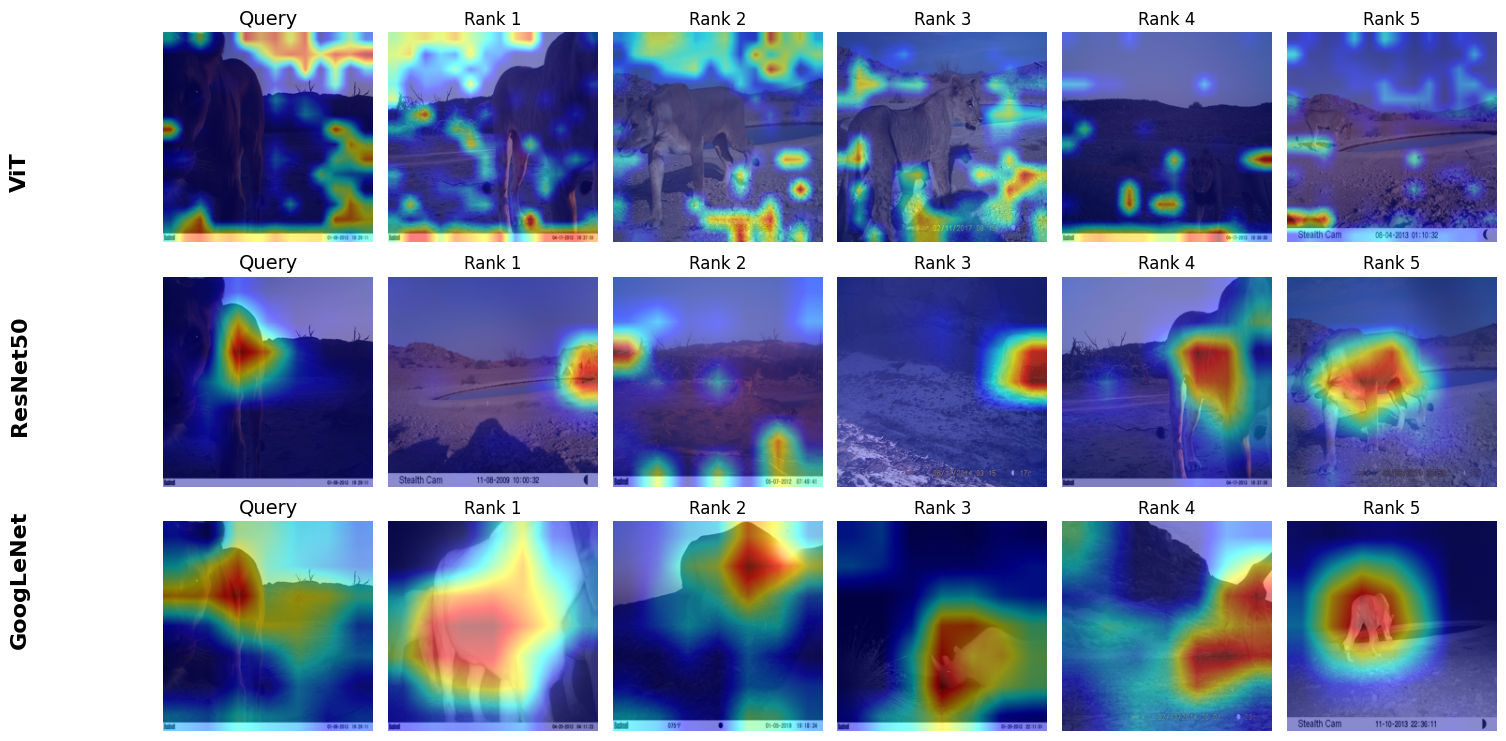

In [39]:
# Modelle laden
learn_resnet = load_learner('../basemodel_outputs/resnet50_bs16+aug+iNat.pkl')
model_resnet = learn_resnet.model
target_layer_resnet = model_resnet[0][-1]

learn_googlenet = load_learner('../basemodel_outputs/googlenet_bs128+aug.pkl')
model_googlenet = learn_googlenet.model
target_layer_googlenet = model_googlenet[0][-1]

learn_vit = load_learner('../basemodel_outputs/ViT_bs64+augm+iNat.pkl')
model_vit = learn_vit.model
target_layer_vit = model_vit.blocks[-1].norm1

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# Modelle zusammenstellen
models_info = [
    {"model": model_vit, "model_name": "ViT", "target_layer": target_layer_vit, "reshape_transform": reshape_transform},
    {"model": model_resnet, "model_name": "ResNet50", "target_layer": target_layer_resnet},
    {"model": model_googlenet, "model_name": "GoogLeNet", "target_layer": target_layer_googlenet},
]

# Grad-CAM Übersicht erstellen
visualize_all_gradcams(
    query_idx=1422,
    df_test=df_test,
    model_outputs=model_outputs,
    models_info=models_info,
    top_k=5,
    save_path="gradcam_combined_query1422.pdf"
)


In [ ]:
# Grad-CAM für abgeschnittene Tiere

# Bild Nr. 5
img_path = "../balanced_dataset_split/balanced_dataset_split/test/loxodanta africana/loxodanta africana_20150127-EK000257.JPG"

# Ground Truth Klasse (aus Pfad)
true_label = "loxodanta africana"

# --- Modelle laden ---
learn_resnet = load_learner('../basemodel_outputs/resnet50_bs16+aug+iNat.pkl')
model_resnet = learn_resnet.model
dls_resnet = learn_resnet.dls  # für decode

learn_googlenet = load_learner('../basemodel_outputs/googlenet_bs128+aug.pkl')
model_googlenet = learn_googlenet.model
dls_googlenet = learn_googlenet.dls

learn_vit = load_learner('../basemodel_outputs/ViT_bs64+augm+iNat.pkl')
model_vit = learn_vit.model
dls_vit = learn_vit.dls

# --- ViT braucht reshape_transform ---
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# --- Grad-CAM Funktion ---
def generate_gradcam(model, img_path, target_layer, device, target_class_idx=None, reshape_transform=None):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)

    targets = None
    if target_class_idx is not None:
        targets = [ClassifierOutputTarget(target_class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    grayscale_cam -= np.min(grayscale_cam)
    grayscale_cam /= (np.max(grayscale_cam) + 1e-8)

    rgb_img = np.array(img.resize((224, 224))) / 255.0
    if rgb_img.shape[-1] == 4:
        rgb_img = rgb_img[..., :3]

    visualization = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

    return visualization

# --- Prediction Funktion ---
def predict_image(learn, img_path):
    img = PILImage.create(img_path)
    pred_class, pred_idx, probs = learn.predict(img)
    return str(pred_class)

# --- Modelle vorbereiten ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_info = [
    {"learn": learn_vit, "model": model_vit.eval().to(device), "model_name": "ViT", "target_layer": model_vit.blocks[-1].norm1, "reshape_transform": reshape_transform},
    {"learn": learn_resnet, "model": model_resnet.eval().to(device), "model_name": "ResNet50", "target_layer": model_resnet[0][-1], "reshape_transform": None},
    {"learn": learn_googlenet, "model": model_googlenet.eval().to(device), "model_name": "GoogLeNet", "target_layer": model_googlenet[0][-1], "reshape_transform": None},
]

# --- Grad-CAM Visualisierung + Originalbild ---
fig, axes = plt.subplots(1, len(models_info) + 1, figsize=(16, 4))  # +1 für Originalbild

# --- Erstes Bild: Original anzeigen ---
img_original = Image.open(img_path).convert('RGB')
axes[0].imshow(img_original.resize((224, 224)))
axes[0].set_title("Original", fontsize=14, color='black', pad=10)
axes[0].axis('off')

# Ground Truth unter dem Originalbild anzeigen
axes[0].text(
    0.5, -0.05, true_label,  # gleiche Höhe wie bei den anderen Bildern
    fontsize=12,
    color='black',
    ha='center',
    va='top',
    transform=axes[0].transAxes
)

# --- Dann Grad-CAMs der Modelle ---
for model_idx, model_info in enumerate(models_info):
    learn = model_info["learn"]
    model = model_info["model"]
    model_name = model_info["model_name"]
    target_layer = model_info["target_layer"]
    reshape_func = model_info.get("reshape_transform", None)

    # Grad-CAM generieren
    gradcam_overlay = generate_gradcam(
        model=model,
        img_path=img_path,
        target_layer=target_layer,
        device=device,
        reshape_transform=reshape_func
    )

    # Vorhersage
    pred_label = predict_image(learn, img_path)
    correct = (pred_label == true_label)
    color = 'green' if correct else 'red'

    # Plot in der richtigen Achse
    ax = axes[model_idx + 1]

    ax.imshow(gradcam_overlay)
    ax.axis('off')

    ax.set_title(f"Grad-CAM {model_name}", fontsize=14, color='black', pad=10)

    ax.text(
        0.5, -0.05, pred_label,
        fontsize=12,
        color=color,
        ha='center',
        va='top',
        transform=ax.transAxes
    )


plt.tight_layout()
save_path = "gradcam_comparison_truncated.pdf"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Gespeichert: {save_path}")


✅ Gespeichert: gradcam_comparison_truncated.pdf
